In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint, quad
from scipy import interpolate
from matplotlib.widgets import Slider, Button
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import scipy as sp
import sympy as smp
from scipy.integrate import quad
from scipy.special import spherical_jn

!pip install tqdm
from tqdm import tqdm

In [82]:
def init_params(h=0.7,omega_b = 0.053,omega_k = 0,omega_m = 0.229,omega_de = 0.7709,printing = 'False'):
    """Computes the multiple parameters needed directly derived from the initial conditions"""
    #Hubble today in 1/Mpc
    H_0 = 1/2997.9 * h
    omega_ph = 5.04E-5
    omega_c = omega_m - omega_b
    
    f_nu = 1.68

    omega_r = f_nu*omega_ph

    a_rec = 1/1100

    a_eq = omega_r/omega_m

    alpha = np.sqrt(a_rec/a_eq)

    tau_r = np.sqrt(4*a_rec/omega_m/H_0**2) #constant tau_r in Mpc
    
    #integration limits
    xi = 1E-6

    kmin = 0.01
    kmax = 300
    
    def tau(a, o_r, o_m, o_k, o_de):
        
        integrand = lambda x: 1/(H_0*x**2)*1/(np.sqrt(o_r/x**4+o_m/x**3+ o_k/x**2+o_de))
        
        tau_value , error = quad(integrand, 10**-15,a)
        
        return tau_value
    
    tau_rec = tau(a_rec, omega_r, omega_m, omega_k, omega_de)
    x_rec = tau_rec/tau_r #note the difference between tau_rec which is the conformal time at recombination
    #tau_r is really a rescaling parameter
    
    tau_0 = tau(1, omega_r, omega_m, omega_k, omega_de)
    tau_L = tau_0 - tau_rec #conformal time distance to recombination
    
    
    
    if printing == 'True':
        print(f'Initial parameters and derived quantities:')
        print(f'h = {h}, H_0 = {H_0}')
        print(f'omega_b = {omega_b}, omega_k = {omega_k}, omega_ph ={omega_ph}, omega_c = {omega_c}, omega_de = {omega_de}')
        print(f'Tau_r ={tau_r}, x_rec = {x_rec}')
        print(f'Tau_0 = {tau_0}, tau_rec = {tau_rec} and tau_L = {tau_L}')
        
    return (h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,f_nu,omega_r, a_rec, a_eq, alpha,tau_r,xi, x_rec, tau_0, tau_L)

h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,f_nu,omega_r, a_rec, a_eq, alpha,tau_r, xi, x_rec, tau_0, tau_L = init_params(printing='True')

def y(x):
    "computes scale factor y = a/a_eq in terms of time variable x = tau/tau_r, where tau is conformal time"

    return (alpha*x)**2+2*alpha*x

def yb(x):
    """computes y_b"""
    return omega_b/omega_m * y(x)

def yc(x):
    """computes y_c"""
    return omega_c/omega_m * y(x)

def eta(x):
    "computes hubble in rescaled units eta = (1/a)*da/dx"
    
    return 2*alpha*(alpha*x+1)/y(x)


Initial parameters and derived quantities:
h = 0.7, H_0 = 0.00023349678108008936
omega_b = 0.053, omega_k = 0, omega_ph =5.04e-05, omega_c = 0.17600000000000002, omega_de = 0.7709
Tau_r =539.6783723501918, x_rec = 0.5483057378846716
Tau_0 = 15445.17845628814, tau_rec = 295.9087481718705 and tau_L = 15149.26970811627


In [90]:
lvals= np.arange(10,1500,1)

def power_spectrum(l_list):
    """Computes the power spectrum for a taken list of l-values"""
    #setting the x (temporal) and k (momenta/wavemodes) spaces
    x = np.linspace(xi, x_rec, 1000)
    kvals = np.logspace(-2.,3.,2000)
    
    sols_phi = np.zeros((len(x),len(kvals)))
    sols_dc = np.zeros((len(x),len(kvals)))
    sols_vc = np.zeros((len(x),len(kvals)))
    sols_dg = np.zeros((len(x),len(kvals)))
    sols_vg = np.zeros((len(x),len(kvals)))
    
    def y(x):

        return (alpha*x)**2+2*alpha*x

    def yb(x):
        return omega_b/omega_m * y(x)

    def yc(x):
        return omega_c/omega_m * y(x)

    def eta(x):
        return 2*alpha*(alpha*x+1)/y(x)
    
    def eom(Y,x,k):

    #unpack Y
        phi, dc, vc, dg, vg = Y

    #define dY/dx
        dphi = - eta(x) * phi + ( 3*eta(x)**2 / 2 / k ) * ( vg * ( 4/3 + y(x) - yc(x) ) + vc * yc(x) ) / (1 + y(x))

        ddc = - k * vc + 3 * dphi

        dvc = - eta(x) * vc + k * phi

        ddg = - 4 / 3 * k * vg + 4 * dphi 
    
        dvg = 1 / (1 + 3 / 4 * yb(x) ) * ( - 3 / 4 * yb(x) * eta(x) * vg + 1 / 4 * k * dg ) + k * phi

        dY = [ dphi, ddc, dvc, ddg, dvg ]
    
        return dY

    def Y0(x,k):
        phi0 = 1.
        dg0 = -2 * phi0
        dc0 = 3 / 4 * dg0
        vg0 = - 1 / 4 * k / eta(x) * dg0
        vc0 = vg0

        return [phi0, dc0, vc0, dg0, vg0]
    
    
    
    
    
    #Solves the coupled EOM to get the monopole and dipole solutions for all the k spectrum evaluated at a_rec
    def solution_0_rec(kvalue):
        Yini = Y0(xi,kvalue)
        sol = odeint(eom, Yini, x, args=(kvalue,))
        return sol[-1,0]+1/4*sol[-1,3]

    def solution_1_rec(kvalue):
        Yini = Y0(xi,kvalue)
        sol = odeint(eom, Yini, x, args=(kvalue,))
        return sol[-1,4]
        
    total_sol_0 = []
    total_sol_1 = []

    #for kvalue in tqdm (kvals, desc = 'Computing Multipoles...'):
    for kvalue in kvals:
        total_sol_0.append(solution_0_rec(kvalue))
        total_sol_1.append(solution_1_rec(kvalue))

    #Getting the interpolation functions for each multipole
    monopole_rec = interpolate.interp1d(kvals, total_sol_0)
    dipole_rec = interpolate.interp1d(kvals, total_sol_1)
    
    #extra parameter calculationb for the functiones involved in the computation of the power spectrum
    tau_r = np.sqrt(4*a_rec/omega_m/H_0**2) #constant tau_r in Mpc
    def tau(a, o_r, o_m, o_k, o_de):
        
        integrand = lambda x: 1/(H_0*x**2)*1/(np.sqrt(o_r/x**4+o_m/x**3+ o_k/x**2+o_de))
        
        tau_value , error = quad(integrand, 10**-10,a)
        
        return tau_value
    
    tau_rec = tau(a_rec, omega_r, omega_m, omega_k, omega_de)  
    tau_0 = tau(1, omega_r, omega_m, omega_k, omega_de)
    tau_L = tau_0 - tau_rec #conformal time distance to recombination

    #damping factor variables
    xs = 0.6*omega_m**(1/4)*omega_b**(-1/2)*a_rec**(3/4)
    sigma = 0.03

    #primordial spectrum 
    
    As = 2.2E-9; 
    ns = 0.967; 
    k_pivot=0.05 #pivot scale 0.05 1/Mpc 
    def primordial_power(k):
        return As * (k/k_pivot)**(ns-1)

    
    def D(k):
        return np.exp( -k**2 * (2*xs**2+sigma**2*x_rec**2) )

    def jl2(x): 
        return 1./2./x/np.sqrt(x**2-1)

    #approxmation of jpl^2*l^2, baumann calls w2
    def jlp2(x):
        return jl2(x)*(x**2-1)/x**2

    def integrand_Cl(x,l):
        return 4*np.pi*( monopole_rec(x*l*tau_r/tau_L)**2*jl2(x) + dipole_rec(x*l*tau_r/tau_L)**2*jlp2(x) ) * D(x*l*tau_r/tau_L) * primordial_power(x*l/tau_L) / x

    
    def Cl(l):
        eps=1e-10
        xmin = 1.+eps
        xmax = 10
        integral, error = quad(integrand_Cl,xmin,xmax, args=(l,), limit=100)

        return integral
    #setting the desired l_space
    CLs = []
    #for l in tqdm (l_list, desc = 'Computing PS...'):
    for l in l_list:
        value = Cl(l)
        CLs.append(value)
        pass
    
    return CLs

    

Computing Multipoles...: 100%|██████████████| 2000/2000 [00:21<00:00, 91.76it/s]


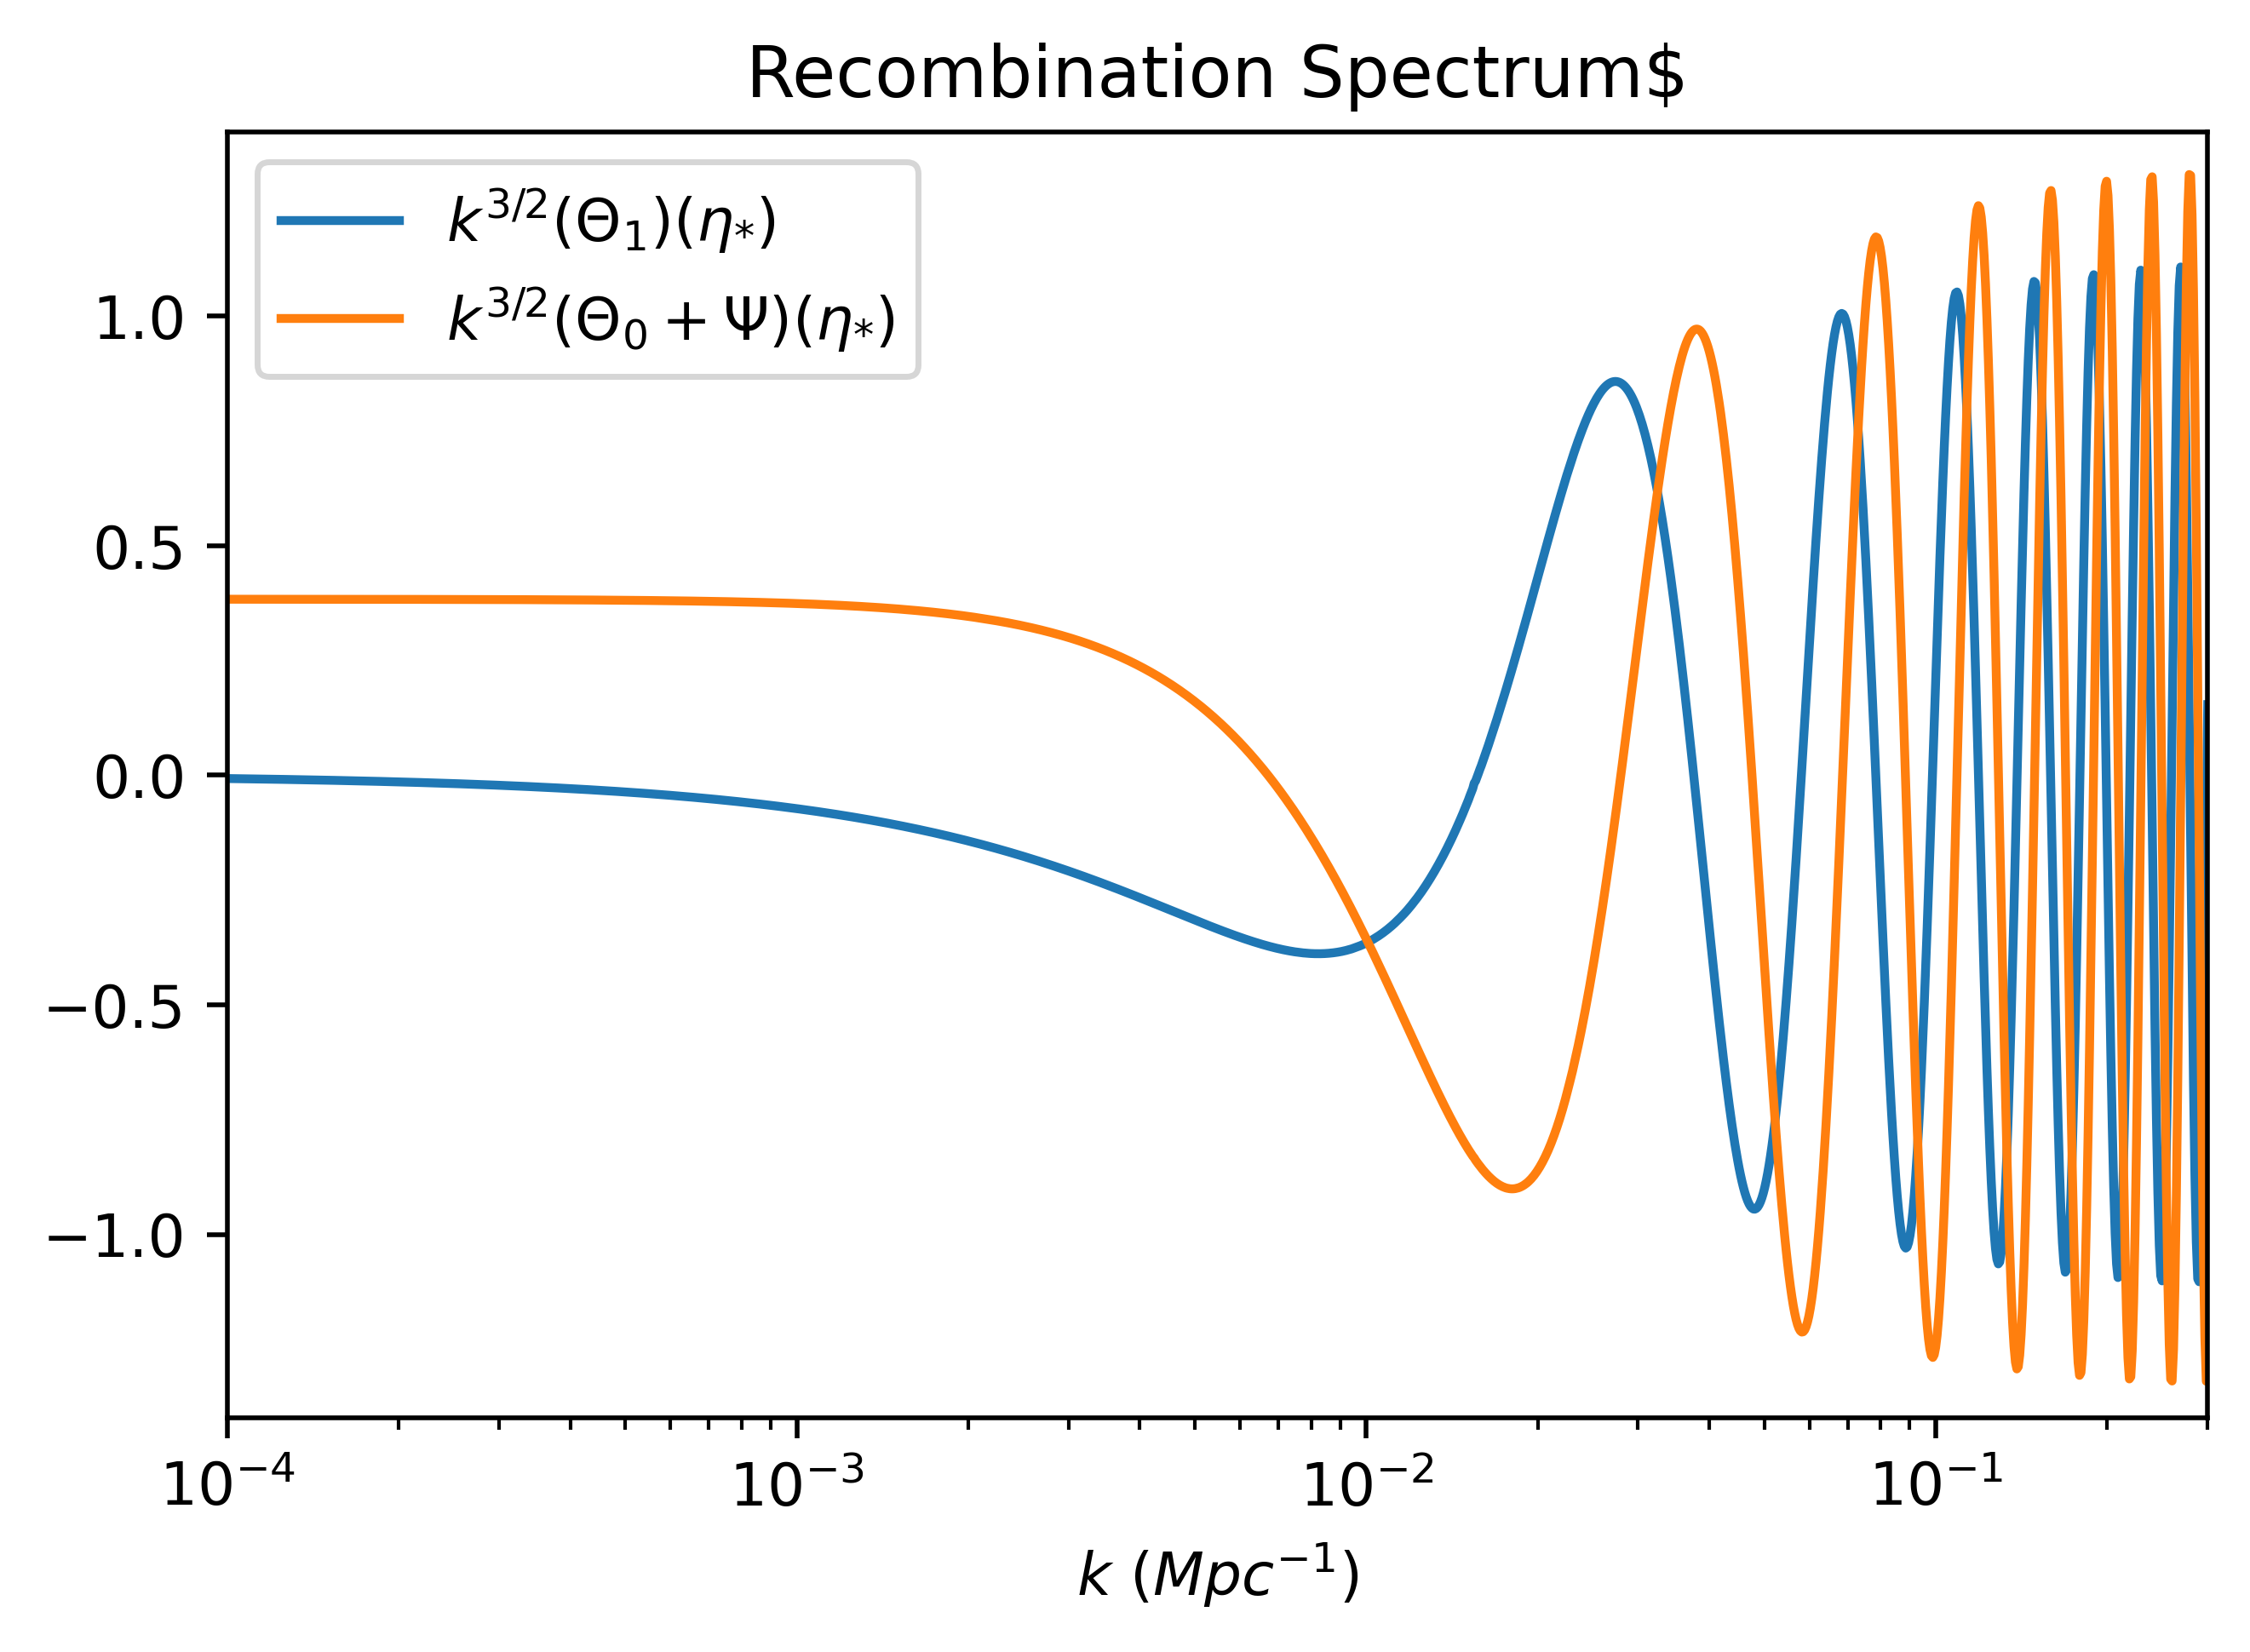

In [88]:
def eom(Y,x,k):

    #unpack Y
    phi, dc, vc, dg, vg = Y

    #define dY/dx
    dphi = - eta(x) * phi + ( 3*eta(x)**2 / 2 / k ) * ( vg * ( 4/3 + y(x) - yc(x) ) + vc * yc(x) ) / (1 + y(x))

    ddc = - k * vc + 3 * dphi

    dvc = - eta(x) * vc + k * phi

    ddg = - 4 / 3 * k * vg + 4 * dphi 

    dvg = 1 / (1 + 3 / 4 * yb(x) ) * ( - 3 / 4 * yb(x) * eta(x) * vg + 1 / 4 * k * dg ) + k * phi

    dY = [ dphi, ddc, dvc, ddg, dvg ]

    return dY

def Y0(x,k):
    phi0 = 1.
    dg0 = -2 * phi0
    dc0 = 3 / 4 * dg0
    vg0 = - 1 / 4 * k / eta(x) * dg0
    vc0 = vg0

    return [phi0, dc0, vc0, dg0, vg0]

def dphi_sep(x):
    phi, dc, vc, dg, vg = Y0(x,k)
    return - eta(x) * phi + ( 3*eta(x)**2 / 2 / k ) * ( vg * ( 4/3 + y(x) - yc(x) ) + vc * yc(x) ) / (1 + y(x))
    



x = np.linspace(xi, x_rec, 1000)
kvals = np.logspace(-2.,3.,2000)


sols_phi = np.zeros((len(x),len(kvals)))
sols_dc = np.zeros((len(x),len(kvals)))
sols_vc = np.zeros((len(x),len(kvals)))
sols_dg = np.zeros((len(x),len(kvals)))
sols_vg = np.zeros((len(x),len(kvals)))

i = 0
for k in tqdm (kvals, desc="Computing Multipoles..."):
  Yini = Y0(xi,k)
  sol = odeint(eom, Yini, x, args=(k,))
  sols_phi[:,i] = sol[:,0]
  sols_dc[:,i] = sol[:,1]
  sols_vc[:,i] = sol[:,2]
  sols_dg[:,i] = sol[:,3]
  sols_vg[:,i] = sol[:,4]
  i = i+1
  pass

fig, axs = plt.subplots(1, 1, dpi = 500)
axs.plot(kvals/tau_r,-1/np.sqrt(3)*sols_vg[-1,:],label= '$k^{3 / 2}(\Theta_{1})(\eta_{*})$')
axs.plot(kvals/tau_r, 1/4*sols_dg[-1,:]+sols_phi[-1,:],label= '$k^{3 / 2}(\Theta_{0}+\Psi)(\eta_{*})$')
axs.set_title(f'Recombination Spectrum$')
axs.set_xlim(1E-4,0.3)
axs.set_xscale('log')
axs.set_ylim(-1.4, 1.4)
axs.set_xlabel('$k$ $(Mpc^{-1})$')
axs.legend()
plt.show()

#fig.savefig('recombination_spectrum.png') #Only run if you want to save the image

Initial parameters and derived quantities:
h = 0.7, H_0 = 0.00023349678108008936
omega_b = 0.053, omega_k = 0, omega_ph =5.04e-05, omega_c = 0.17600000000000002, omega_de = 0.7709
Tau_r =539.6783723501918, x_rec = 0.5483057378846716
Tau_0 = 15445.17845628814, tau_rec = 295.9087481718705 and tau_L = 15149.26970811627


Text(0.5, 1.0, 'Power Spectrum ')

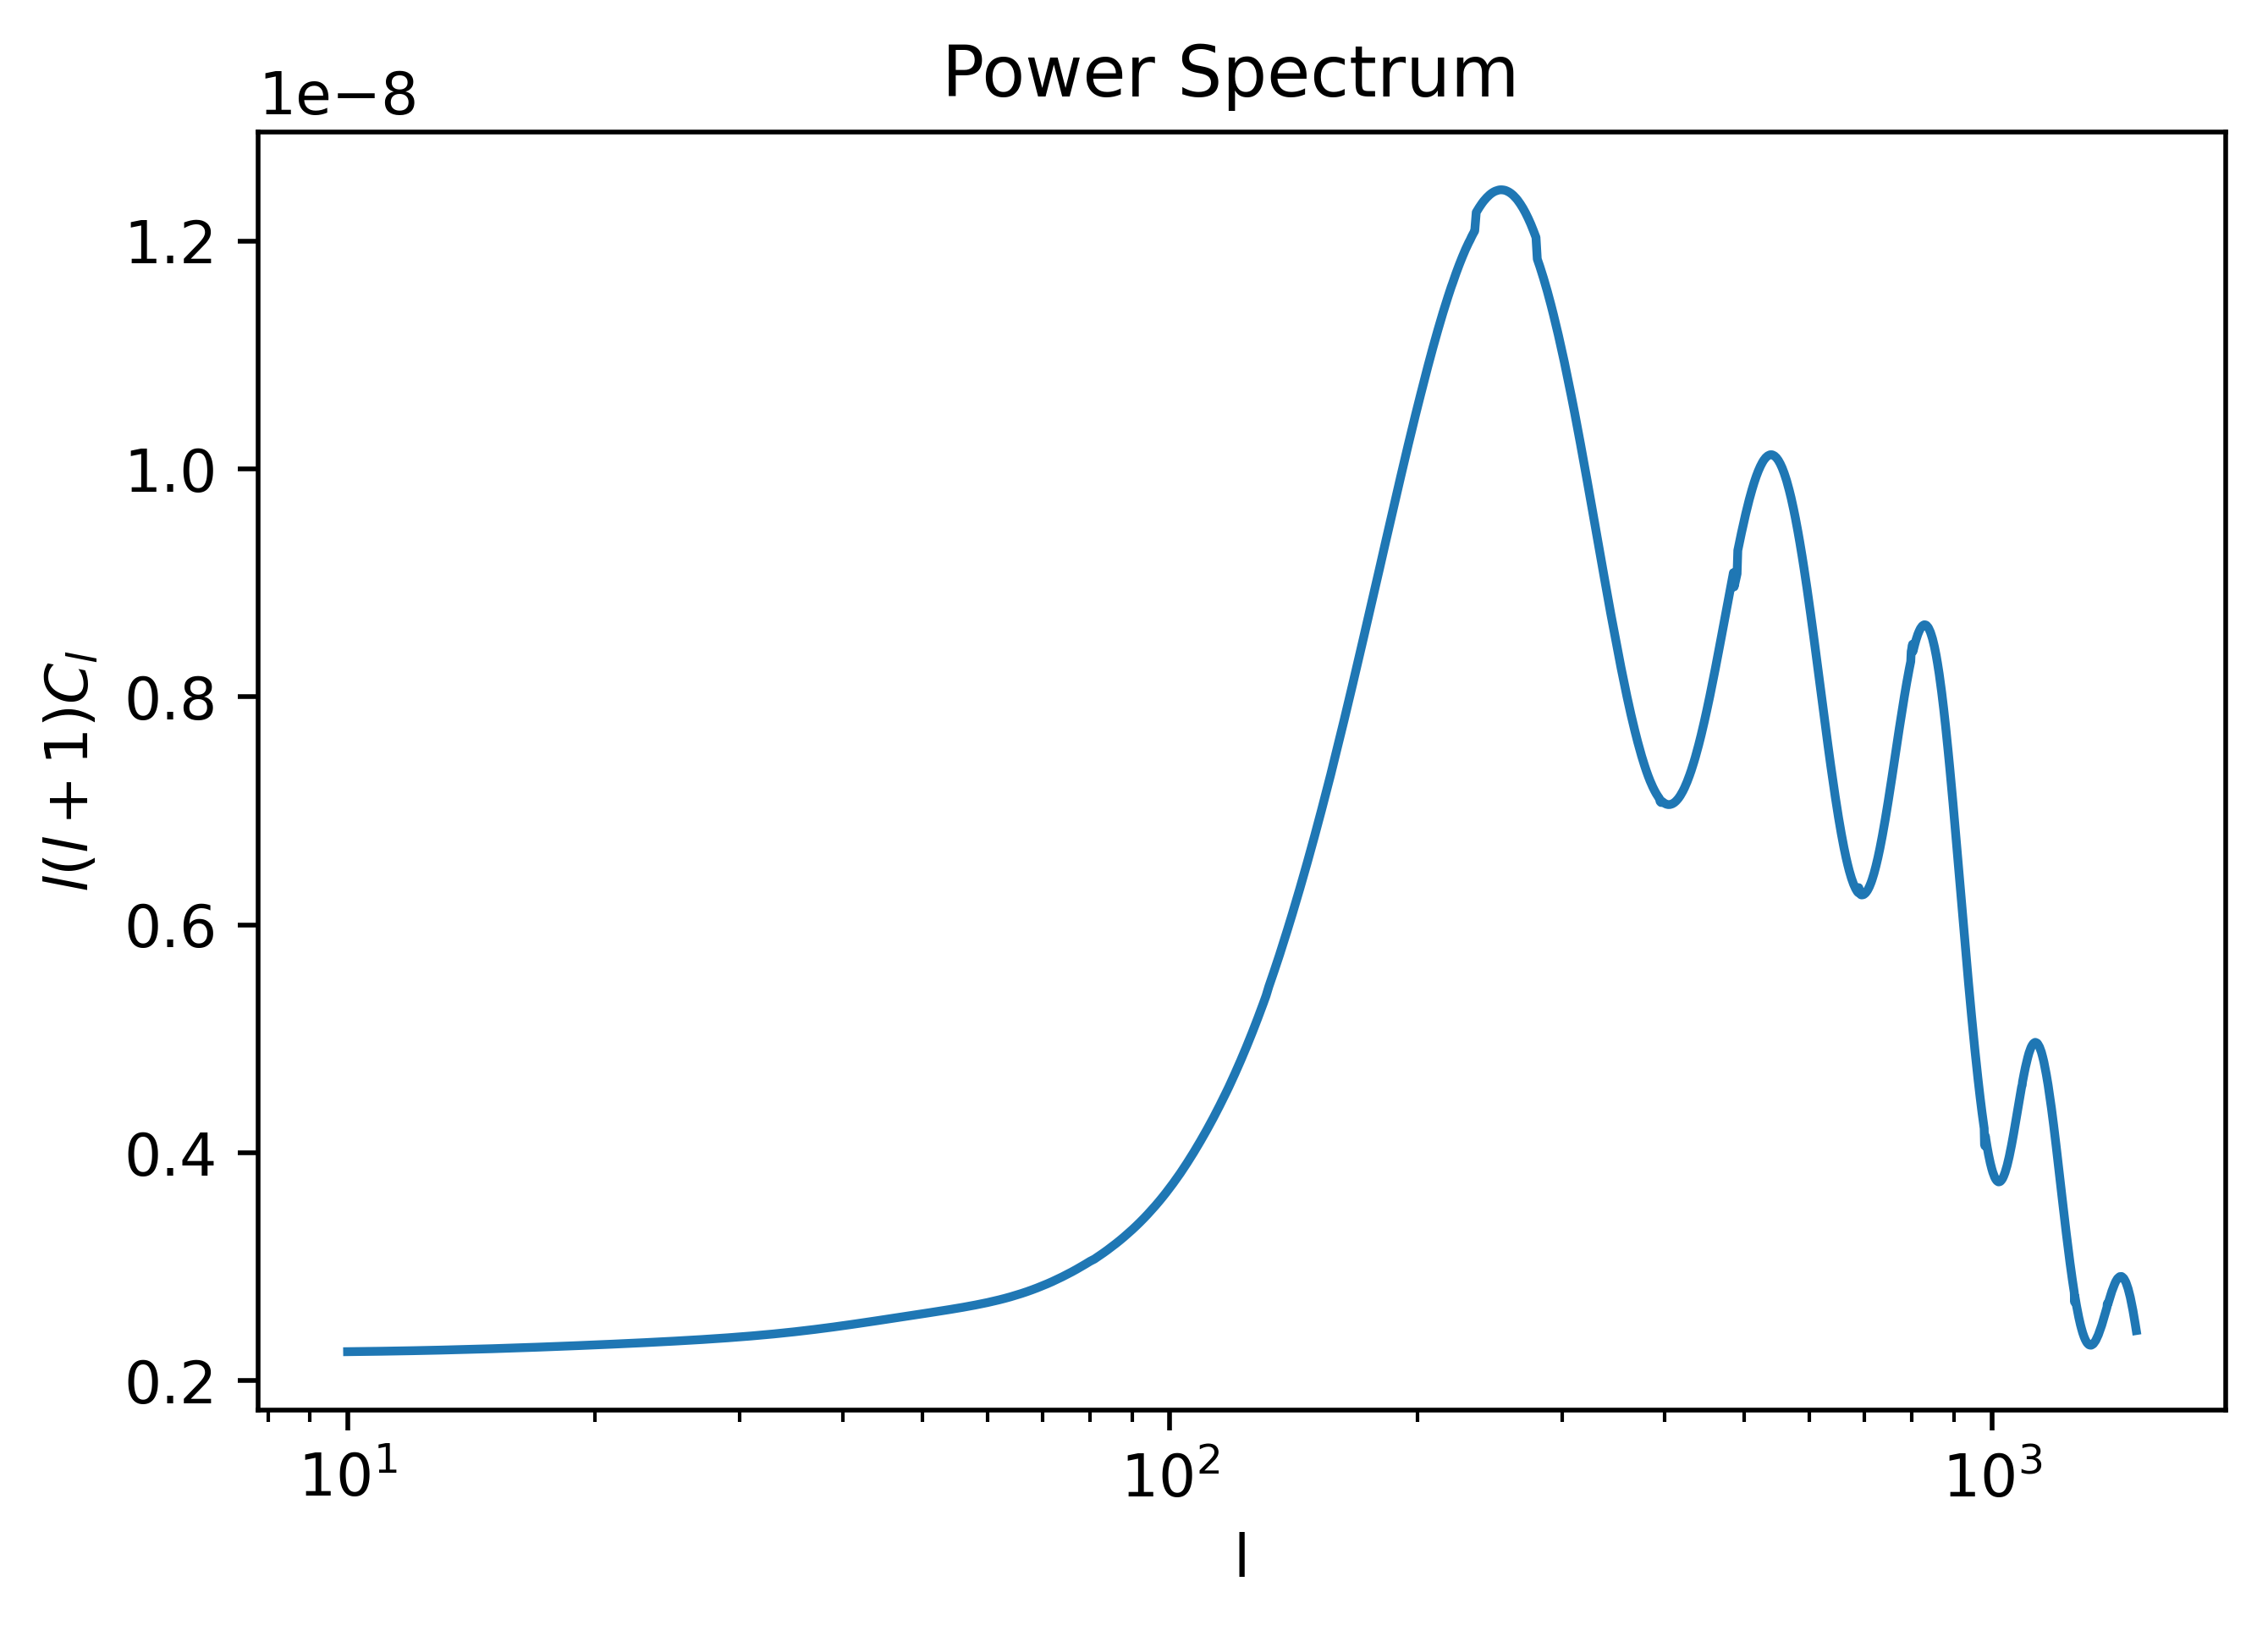

In [91]:
#Computing the power spectrum
#Calculating initial parameters
h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,f_nu,omega_r, a_rec, a_eq, alpha,tau_r, xi, x_rec, tau_0, tau_L = init_params(printing='True')
lvals = np.arange(10,1500,1)
fig, axs = plt.subplots(1, 1, dpi = 500)
plt.plot(lvals,power_spectrum(lvals))
plt.xlabel('l')
plt.ylabel('$l(l+1)C_l$')
plt.xscale('log')
plt.title(f'Power Spectrum ')
#fig.savefig('power_spectrum_1.png')   #Only run if you want to save the image

In [92]:
#Here I a creating a plotting function
import matplotlib as mpl
import matplotlib.pyplot as plt

def plotting_colorbar(parameter_list, x_axis, y_list, variable = 'False'):
    """This function just plots with the desired color bar associated to the parameter being varied.
    
        Takes the following parameters:
             -parameter_list: Takes a list that contains the multiple values that the varying parameter takes
             
             -x_axis: Takes a list of values for the x axis
             
             -y_list: Takes a list of values for the y axis
             
             -variable: If True, prints the name of the variable being varied over. Takes False by default.
    
    
    """
    fig, axs = plt.subplots(1,1,dpi=500)
    step = (max(parameter_list)-min(parameter_list))/len(parameter_list)
    steps = len(parameter_list)

    # Setting up a colormap that's a simple transtion
    mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

    # Using contourf to provide my colorbar info, then clearing the figure
    Z = [[0,0],[0,0]]
    levels = np.arange(min(parameter_list),max(parameter_list)+step,step)
    CS3 = plt.contourf(Z, levels, cmap=mymap)
    plt.clf()
        
    
    X= x_axis
    Y= y_list
    Z=np.linspace(min(parameter_list),max(parameter_list),steps)
    for x,y,z in zip(X,Y,Z):
        # setting rgb color based on z normalized to my range
        r = (float(z)-min(parameter_list))/(max(parameter_list)-min(parameter_list))
        g = 0
        b = 1-r
        plt.plot(x,y,color=(r,g,b))
    clb = plt.colorbar(CS3) # using the colorbar info I got from contourf
    clb.ax.set_title(str(variable))
    plt.xscale('log')
    
   # if variable != 'False':
    #    plt.title('Power Spectrum with varying  '+str(variable))
    
    plt.xlabel('l')
    plt.ylabel('$l(l+1)C_l$')
    #plt.title(f'Power Spectrum ')
    plt.tight_layout()



Initial parameters and derived quantities:
h = 0.7, H_0 = 0.00023349678108008936
omega_b = 0.053, omega_k = 0, omega_ph =5.04e-05, omega_c = 0.17600000000000002, omega_de = 0.7709
Tau_r =539.6783723501918, x_rec_old = 0.5483057379799241, x_rec = 0.5483057378846716
Tau_0 = 15445.17845628814, tau_rec = 295.9087481718705 and tau_L = 15149.26970811627


Computing PS: 100%|███████████████████████████████| 5/5 [05:23<00:00, 64.77s/it]
/var/folders/qz/9k0tr9kd64gcnn0nmrvlzkfh0000gn/T/ipykernel_48835/2412171987.py:41: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  clb = plt.colorbar(CS3) # using the colorbar info I got from contourf


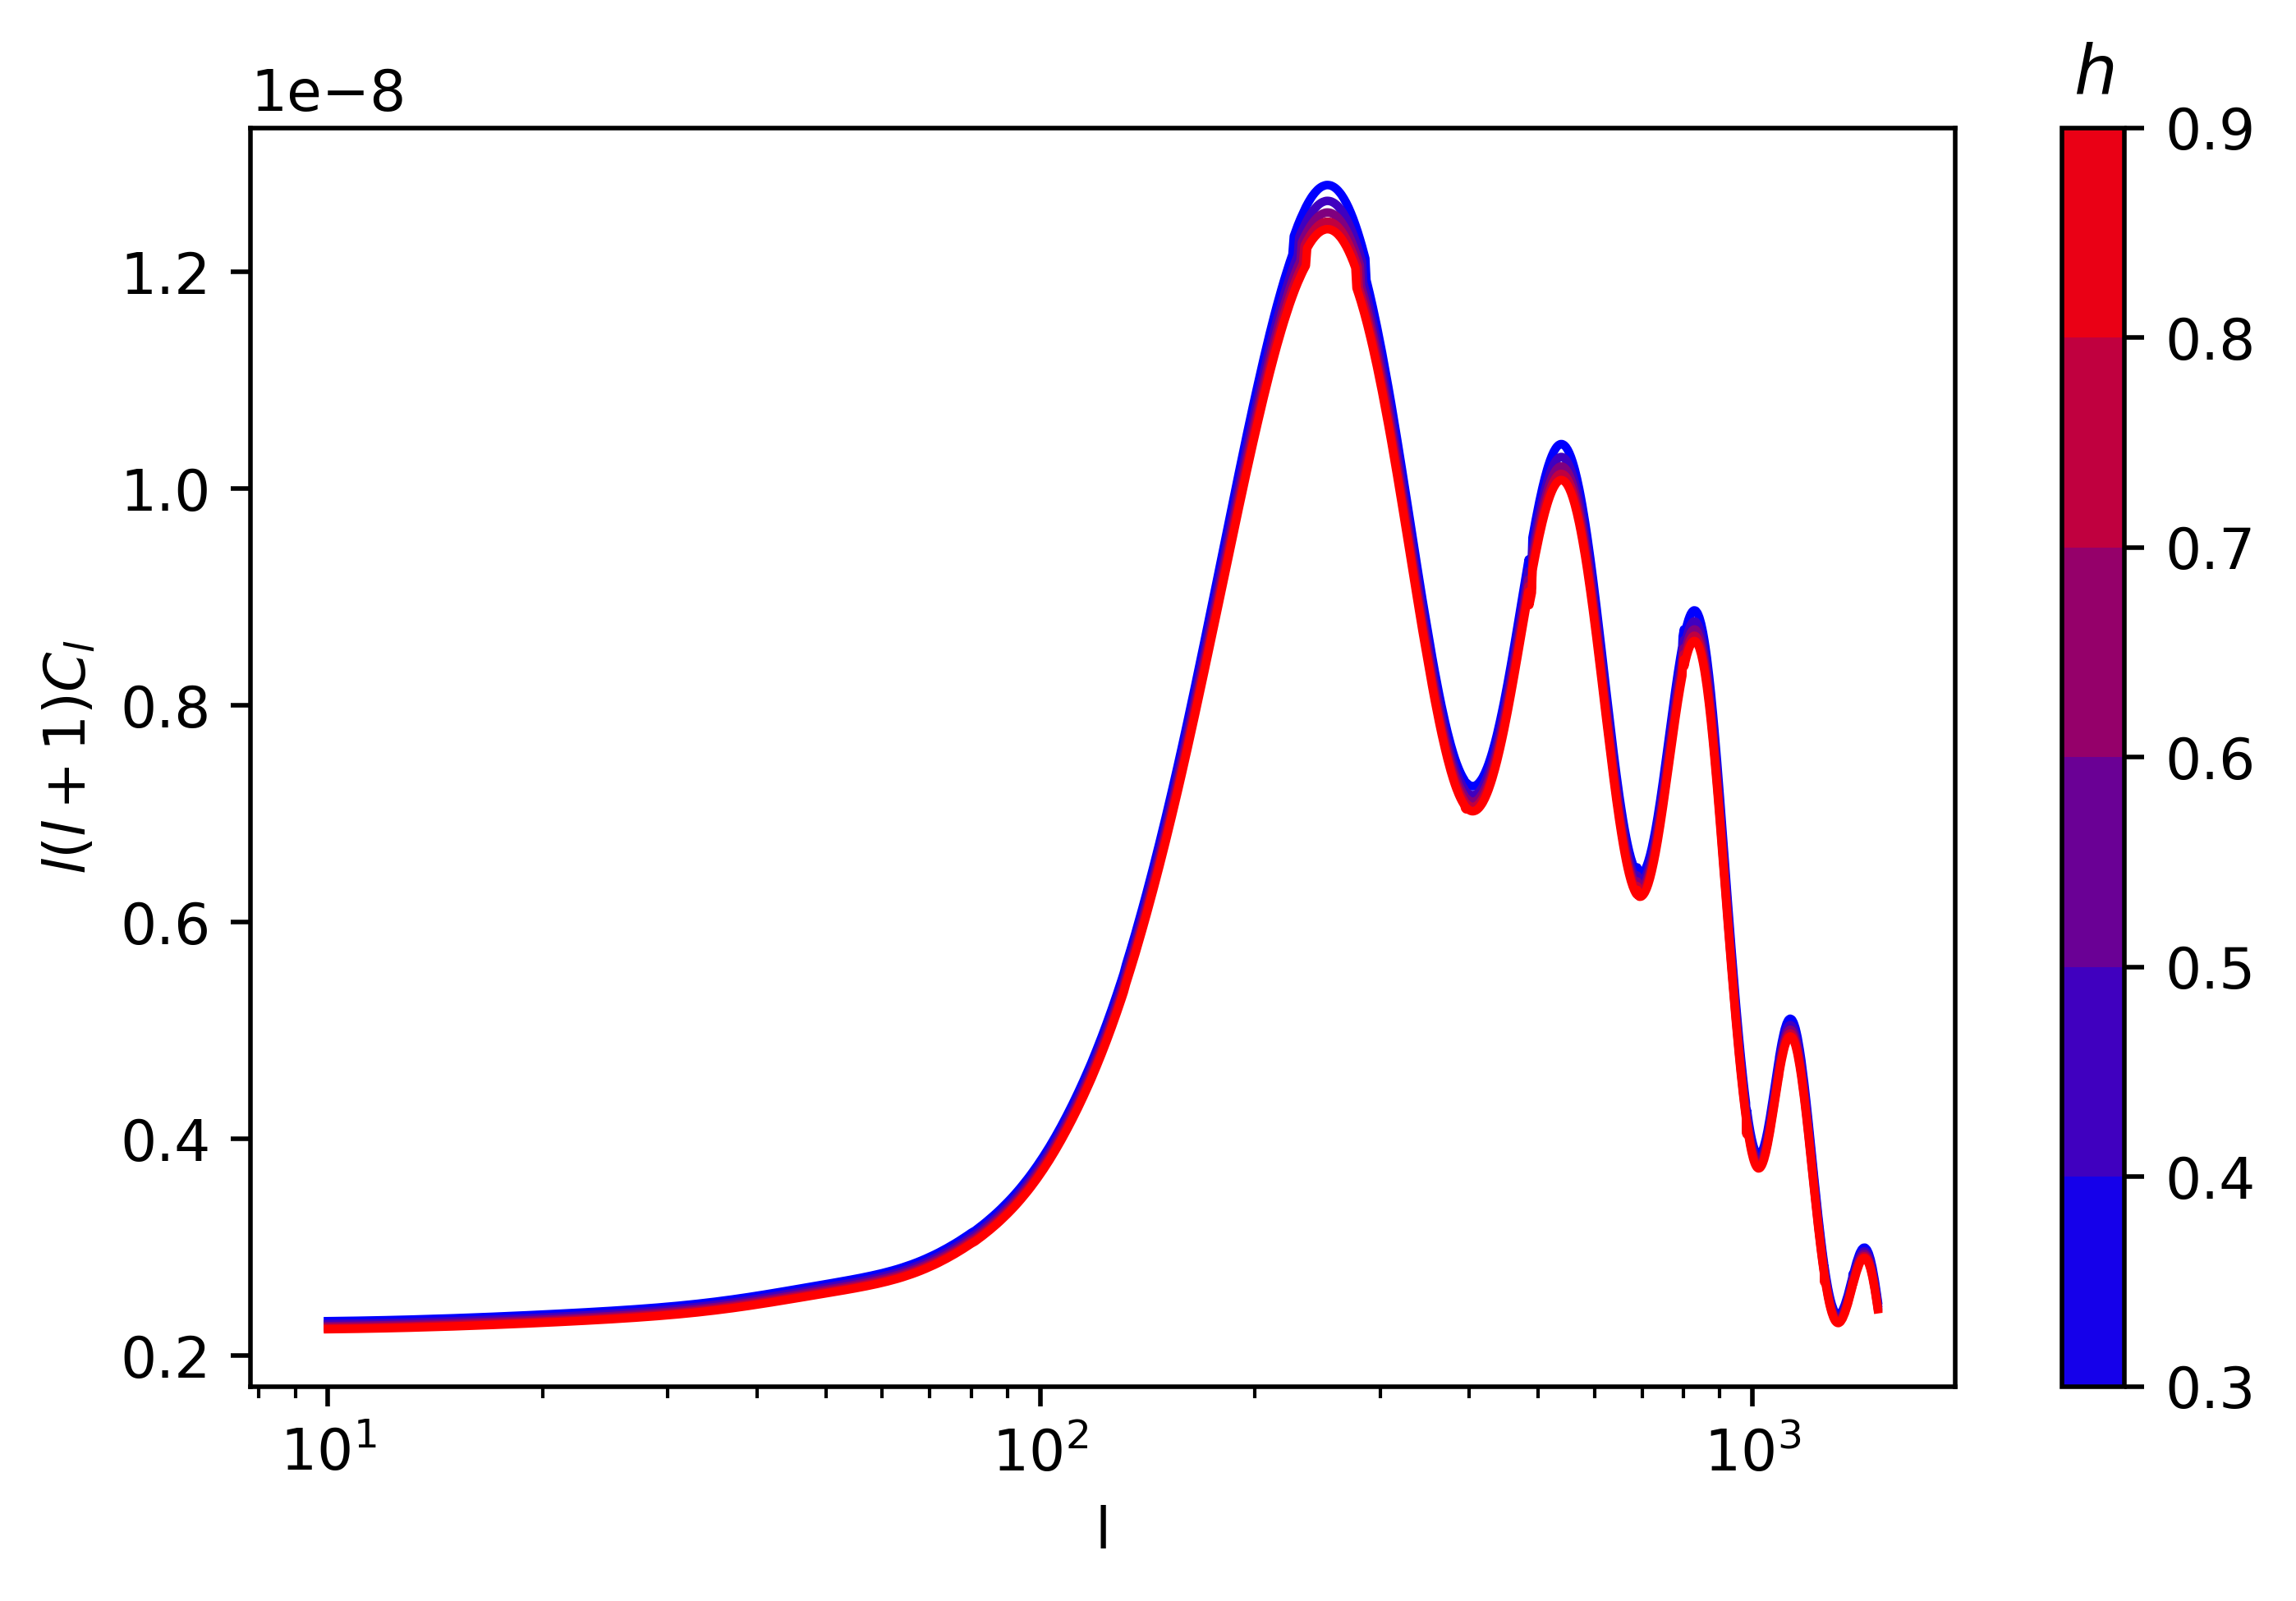

In [59]:
#HERE IS WHERE I VARY THE PARAMETERS CHANGING h

lvals = np.arange(10,1500,1)
h_list = np.linspace(0.3,0.8,5)   #np.linspace(0.053,0.15,3)

results_h_total = []
l_space_total = []
for iteration in tqdm(h_list, desc = 'Computing PS'):
    h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,f_nu,omega_r, a_rec, a_eq, alpha,tau_r,xi, x_rec, tau_0, tau_L = init_params(h = iteration, printing = 'False')
    l_space_total.append(lvals)
    results_h_total.append(power_spectrum(lvals))
    pass


plotting_colorbar(h_list, l_space_total, results_h_total, '$h$')
plt.savefig('PS_h_1')

Computing PS: 100%|███████████████████████████████| 9/9 [06:15<00:00, 41.73s/it]
/var/folders/qz/9k0tr9kd64gcnn0nmrvlzkfh0000gn/T/ipykernel_48835/2412171987.py:41: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  clb = plt.colorbar(CS3) # using the colorbar info I got from contourf


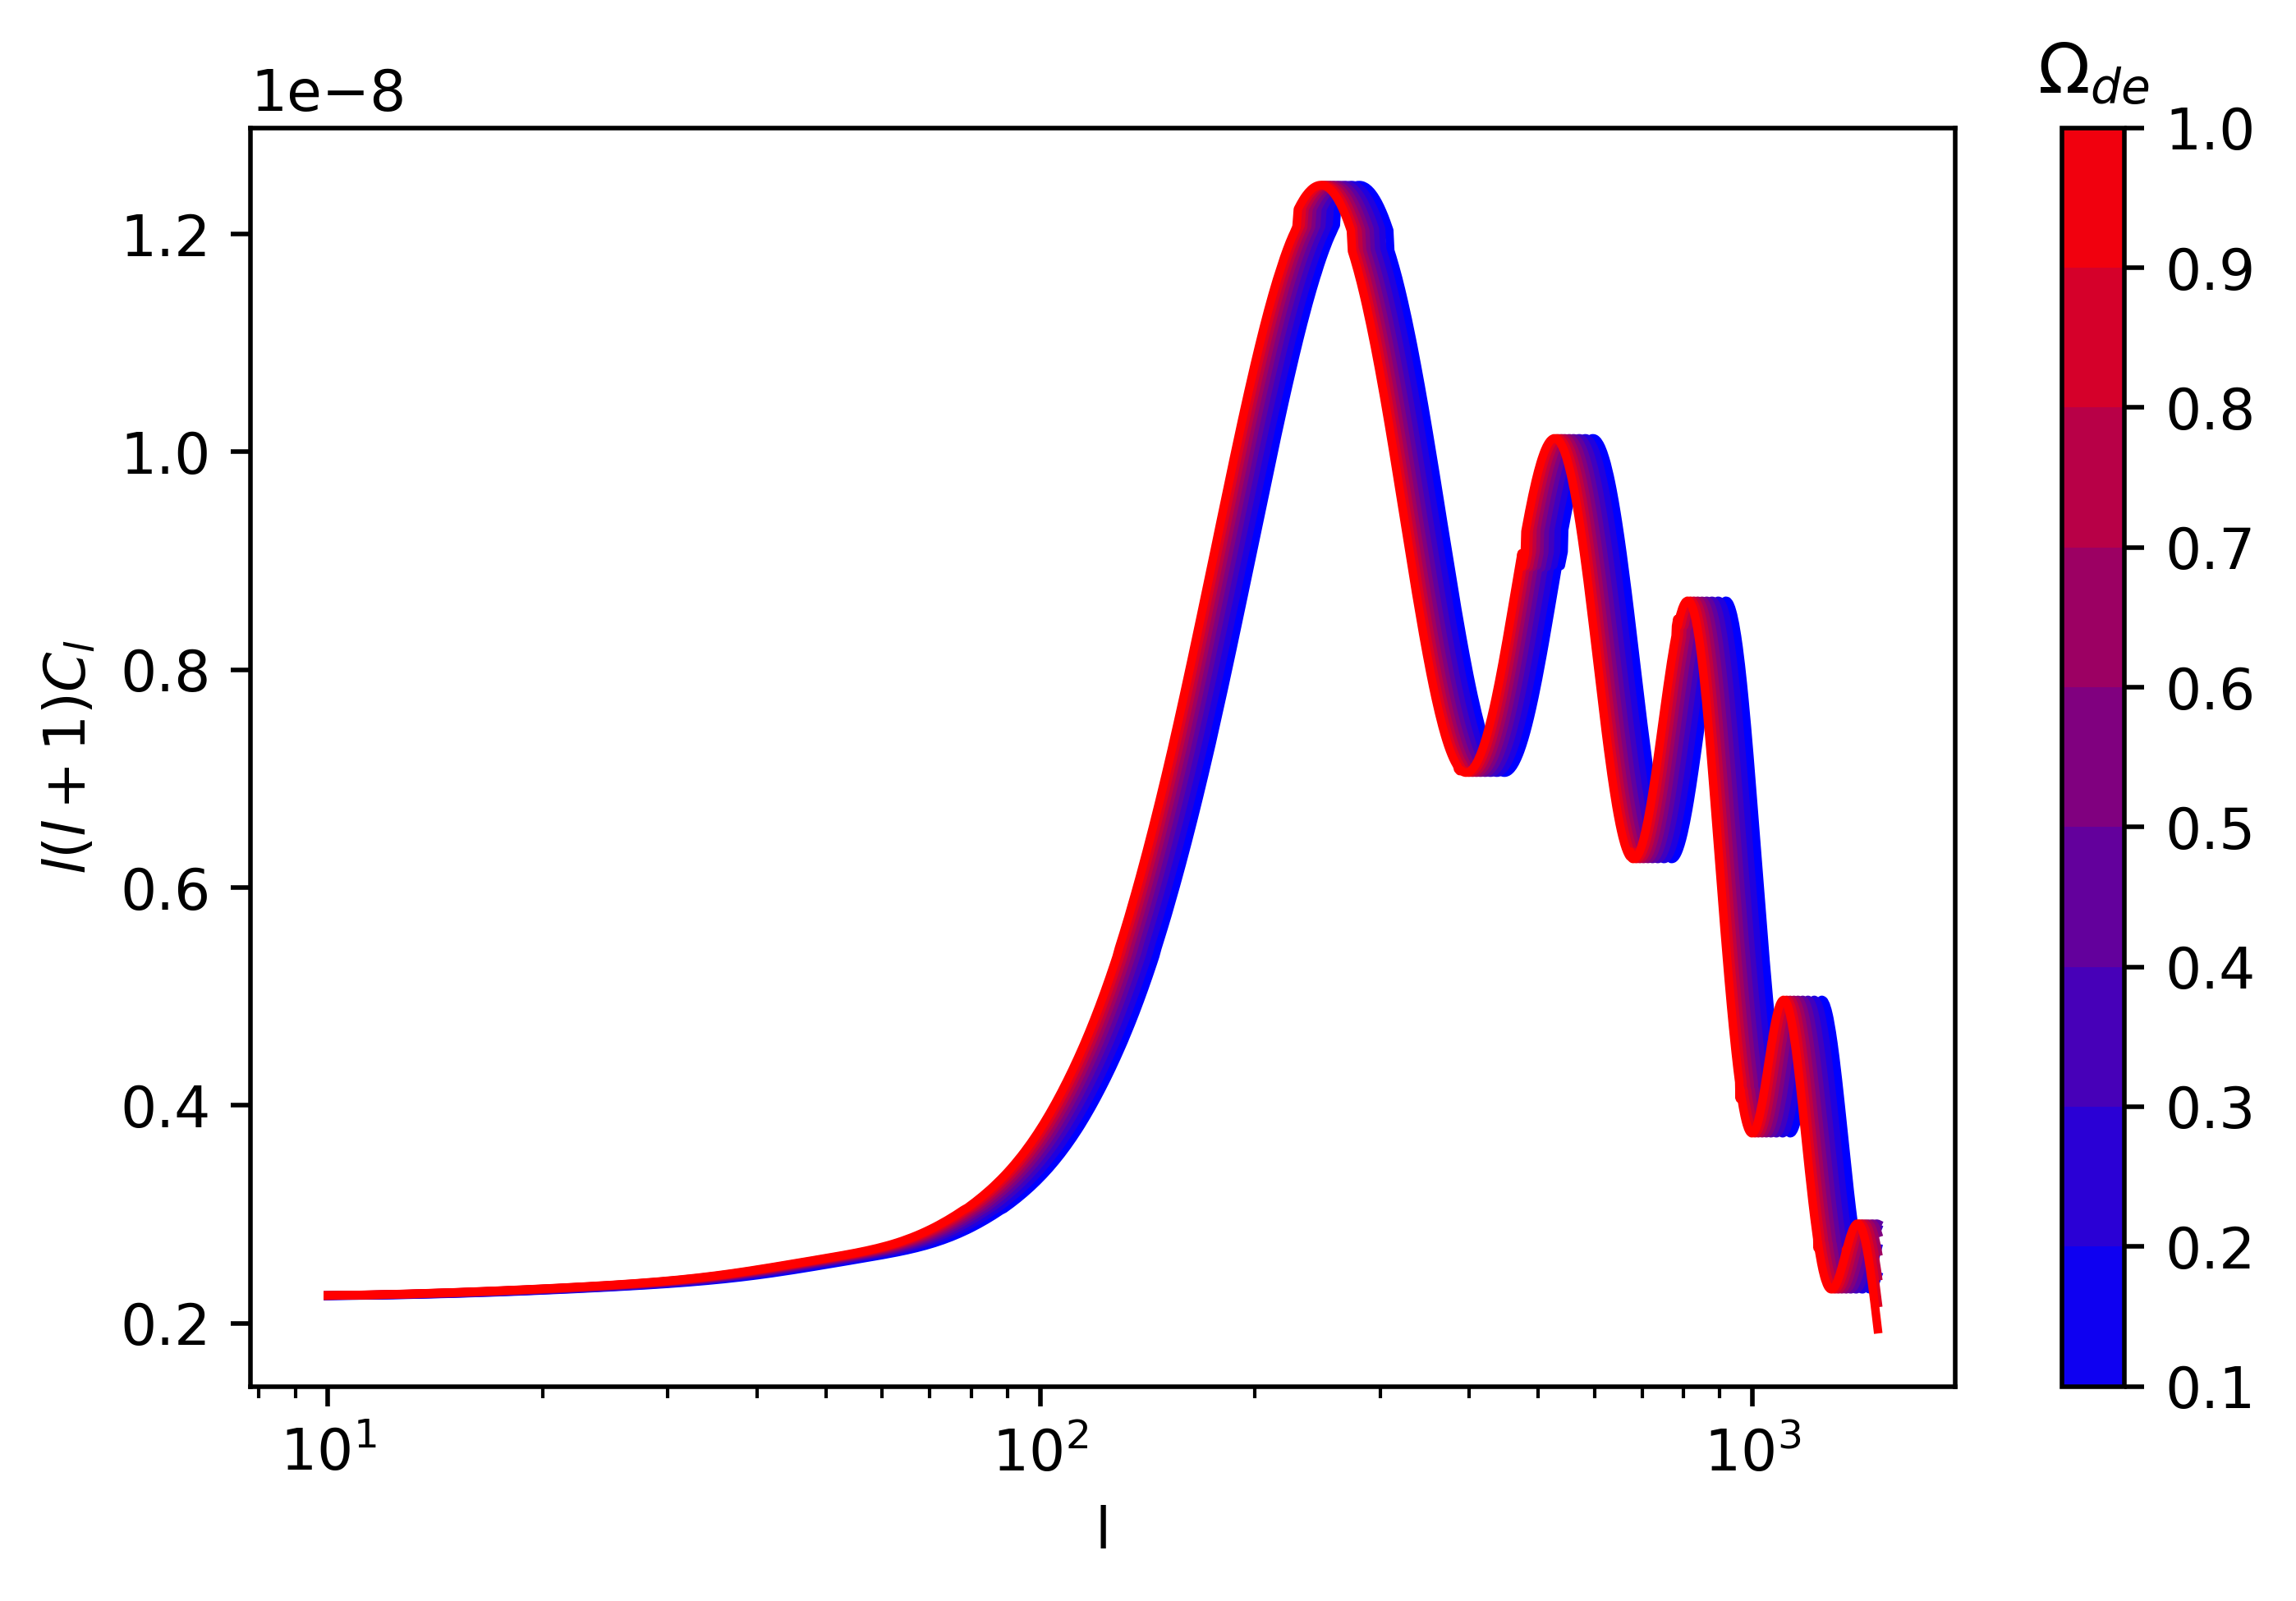

In [77]:
#HERE IS WHERE I VARY THE PARAMETERS omega_de
lvals = np.arange(10,1500,1)
omega_de_list = np.linspace(0.1,1,9)


results_de_total = []
l_space_total = []
for iteration in tqdm(omega_de_list, desc = 'Computing PS'):
    
    h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,f_nu,omega_r, a_rec, a_eq, alpha,tau_r, xi, x_rec, tau_0, tau_L = init_params(omega_de = iteration, printing = 'False')
    l_space_total.append(lvals)
    results_de_total.append(power_spectrum(lvals))  
    pass


plotting_colorbar(omega_de_list, l_space_total, results_de_total, '$\Omega_{de}$')
#plt.savefig('PS_omega_m')

Computing PS: 100%|███████████████████████████████| 6/6 [04:23<00:00, 43.99s/it]
/var/folders/qz/9k0tr9kd64gcnn0nmrvlzkfh0000gn/T/ipykernel_48835/1961258864.py:42: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  clb = plt.colorbar(CS3) # using the colorbar info I got from contourf


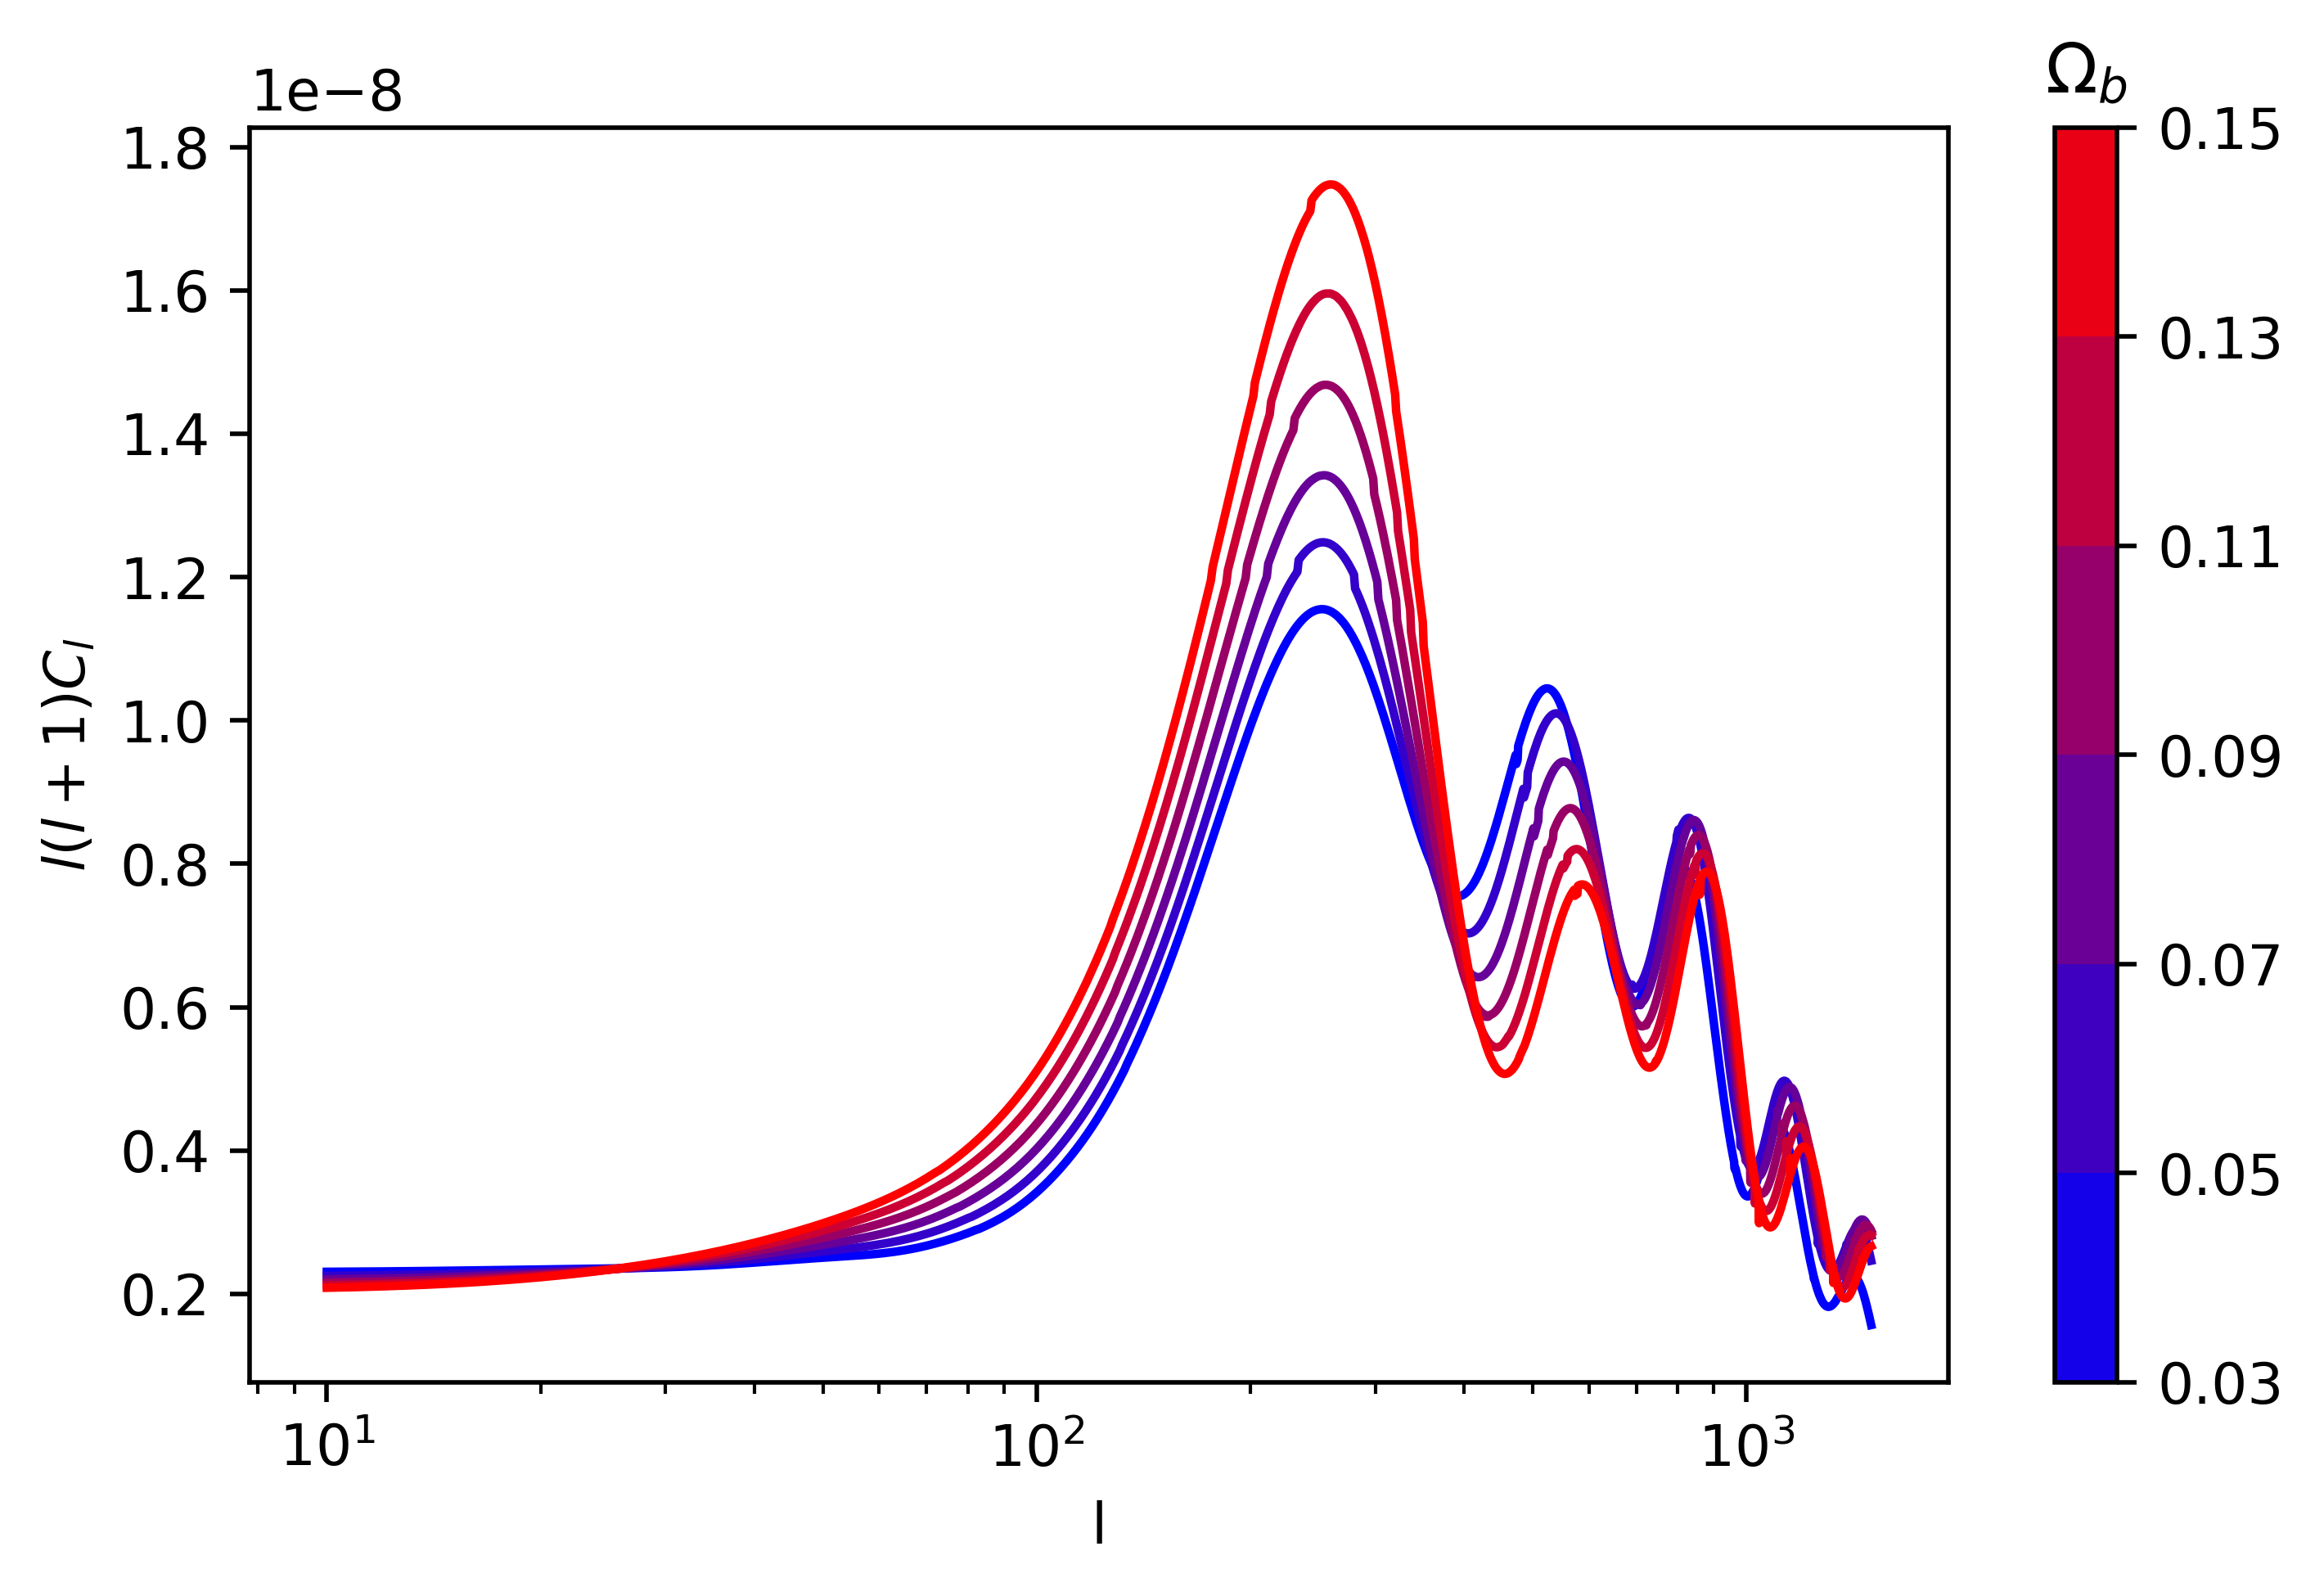

In [93]:
#HERE IS WHERE I VARY THE PARAMETERS CHANGING omega_b
lvals = np.arange(10,1500,1)
omega_b_list = np.linspace(0.03,0.15,6)   #np.linspace(0.053,0.15,3)

results_b_total = []
l_space_total = []
for iteration in tqdm(omega_b_list, desc = 'Computing PS'):
    #print(f'Computing PS for $\Omega_b$ = {iteration}')
    h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,f_nu,omega_r, a_rec, a_eq, alpha,tau_r,xi, x_rec, tau_0, tau_L = init_params_m(omega_b = iteration, printing = 'False')
    l_space_total.append(lvals)
    results_b_total.append(power_spectrum(lvals))

    pass


plotting_colorbar(omega_b_list, l_space_total, results_b_total, '$\Omega_b$')
#plt.savefig('PS_omega_b')

Initial parameters and derived quantities:
h = 0.7, H_0 = 0.00023349678108008936
omega_b = 0.053, omega_k = 0, omega_ph =5.04e-05, omega_c = 0.17600000000000002, omega_de = 0.7709
Tau_r =539.6783723501918, x_rec_old = 0.5483057379799241, x_rec = 0.5483057378846716
Tau_0 = 15445.17845628814, tau_rec = 295.9087481718705 and tau_L = 15149.26970811627


Computing PS: 100%|███████████████████████████████| 5/5 [03:46<00:00, 45.39s/it]
/var/folders/qz/9k0tr9kd64gcnn0nmrvlzkfh0000gn/T/ipykernel_48835/2412171987.py:41: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  clb = plt.colorbar(CS3) # using the colorbar info I got from contourf


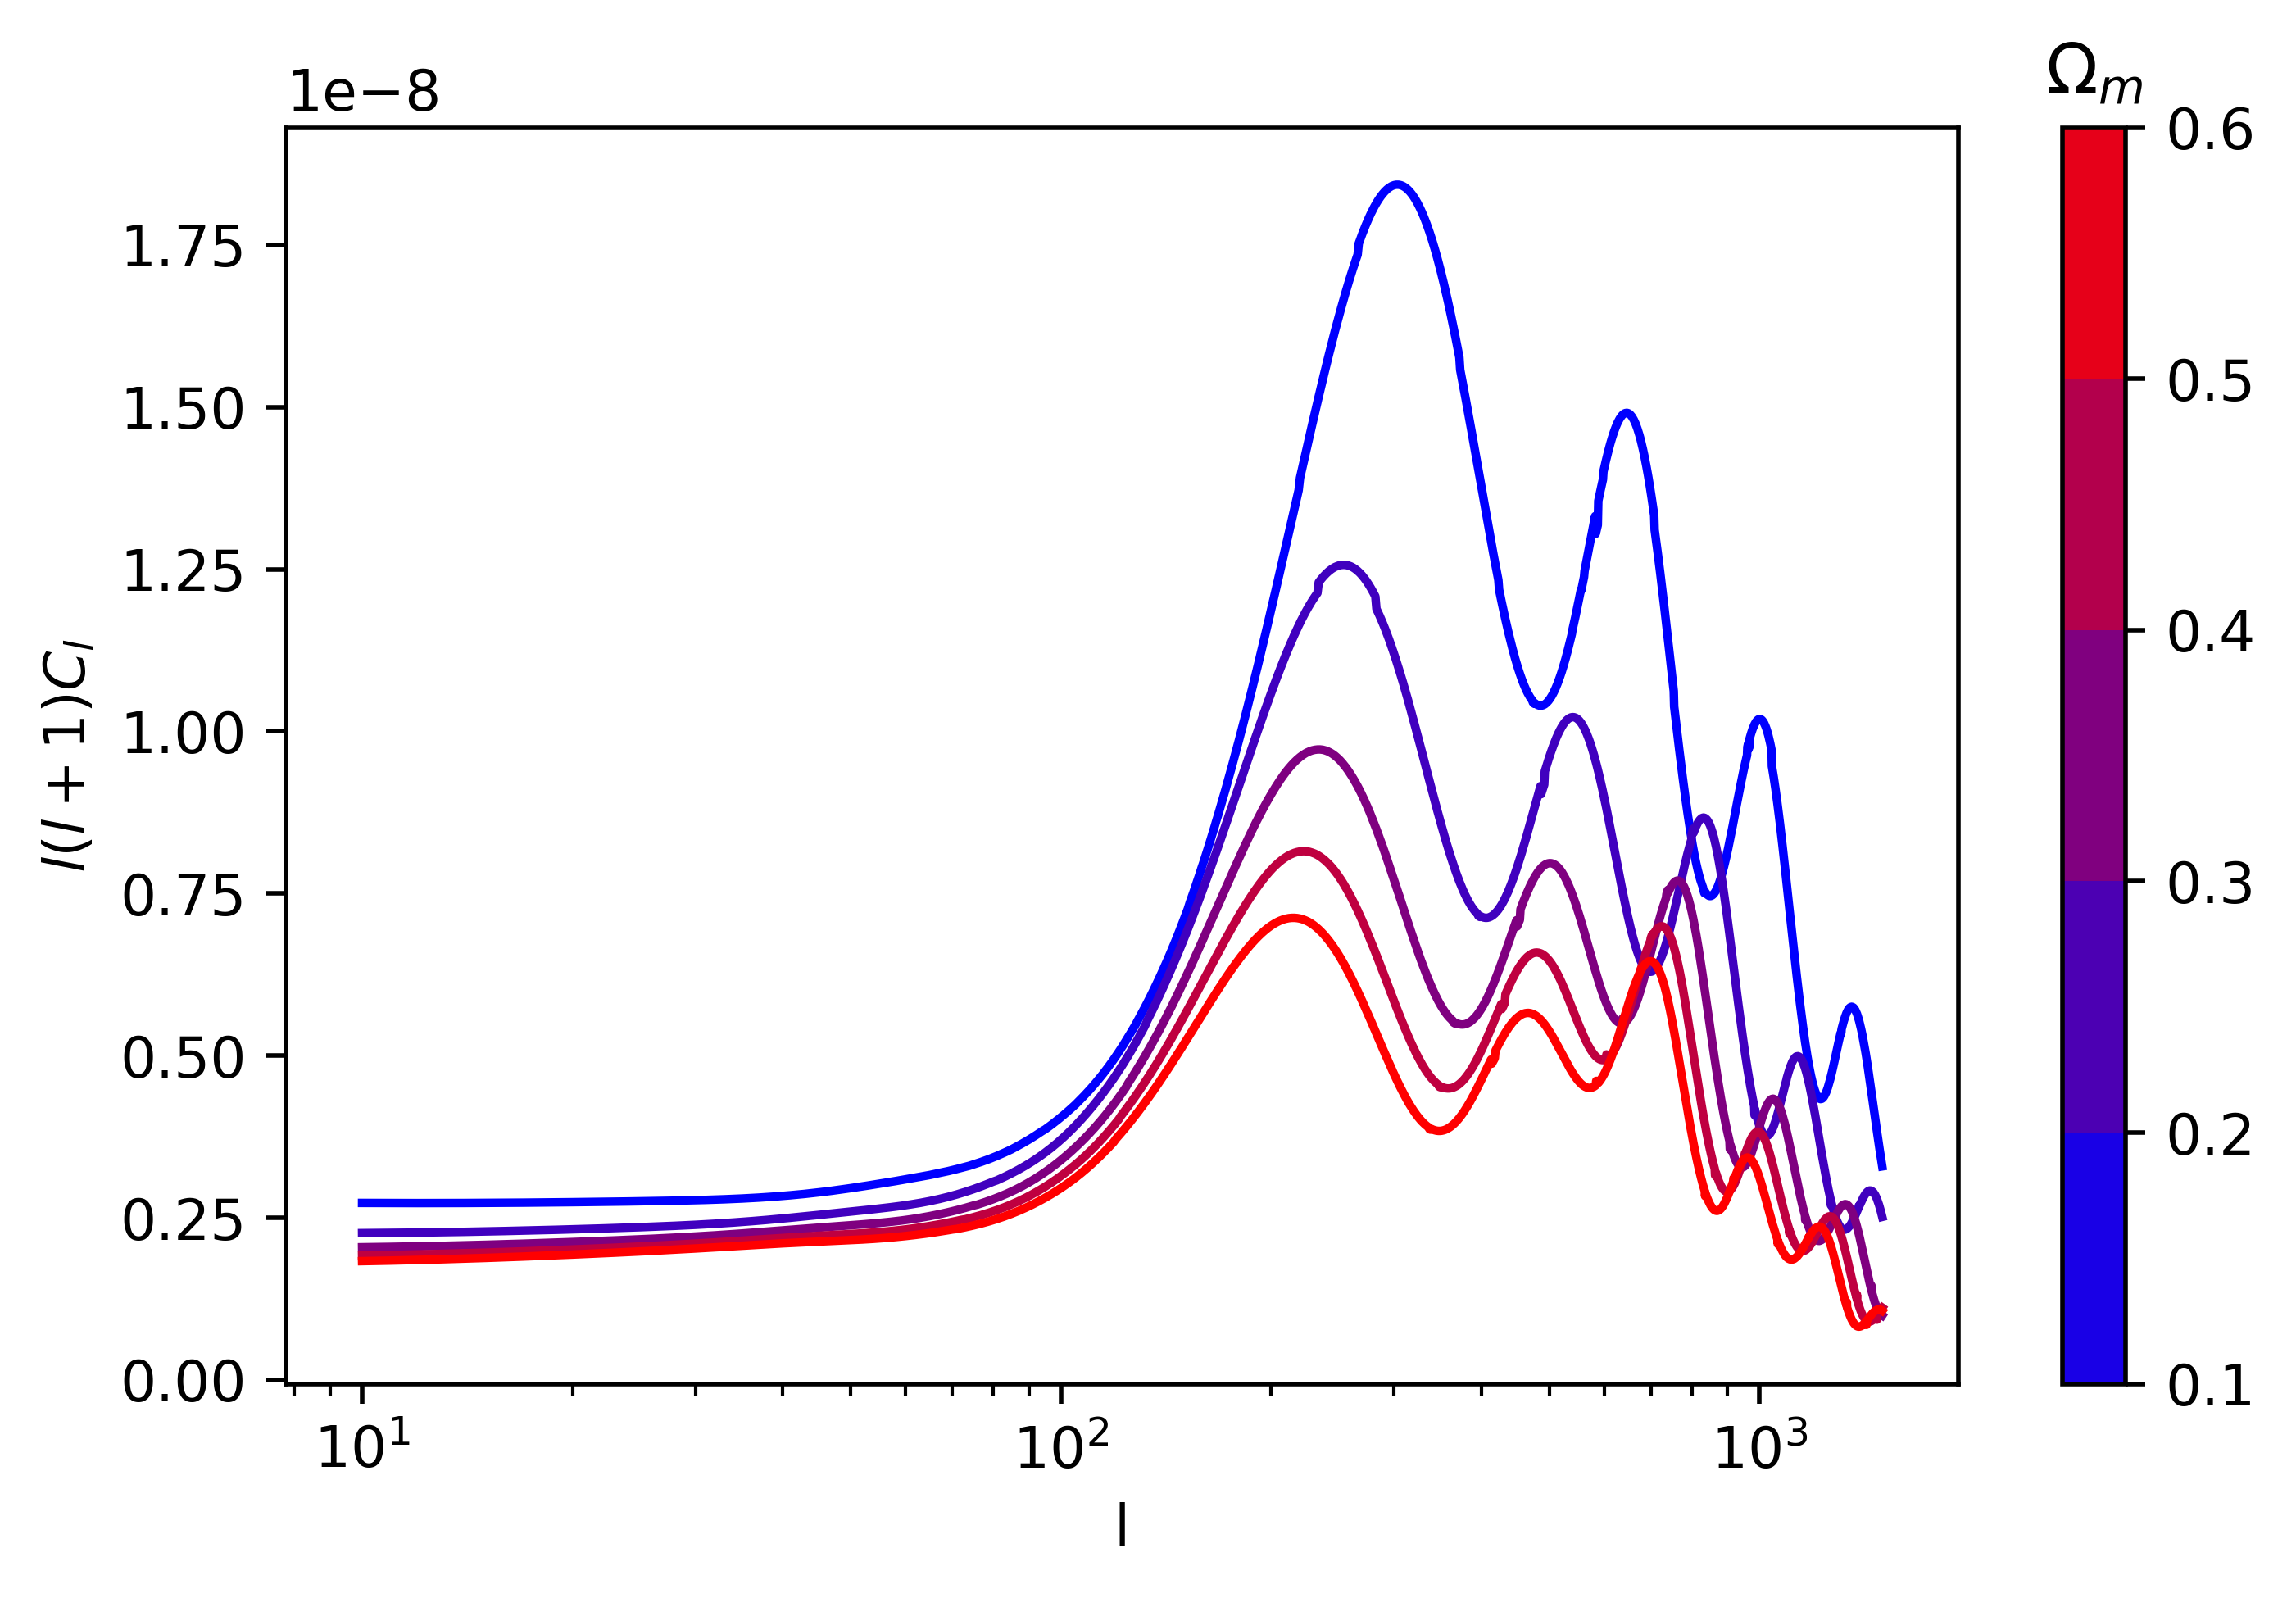

In [70]:
#HERE IS WHERE I VARY THE PARAMETERS CHANGING omega_m

lvals = np.arange(10,1500,1)
omega_m_list = np.linspace(0.1,0.6,5)   #np.linspace(0.053,0.15,3)

results_m_total = []
l_space_total = []
for iteration in tqdm(omega_m_list, desc = 'Computing PS'):
    #print(f'Computing PS for $\Omega_b$ = {iteration}')
    h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,f_nu,omega_r, a_rec, a_eq, alpha,tau_r,xi, x_rec, tau_0, tau_L = init_params(omega_m = iteration, printing = 'False')
    l_space_total.append(lvals)
    results_m_total.append(power_spectrum(lvals))

    pass


plotting_colorbar(omega_m_list, l_space_total, results_m_total, '$\Omega_m$')
#plt.savefig('PS_omega_m_1')

Initial parameters and derived quantities:
h = 0.7, H_0 = 0.00023349678108008936
omega_b = 0.053, omega_k = 4.959999999998299e-05, omega_ph =5.04e-05, omega_c = 0.17600000000000002, omega_de = 0.7709
Tau_r =539.6783723501918, x_rec_old = 0.5483057379799241, x_rec = 0.5483057237485798
Tau_0 = 15444.869942617346, tau_rec = 295.90874054292743 and tau_L = 15148.961202074419


Computing PS for $\Omega_k$: 100%|████████████████| 8/8 [08:45<00:00, 65.68s/it]
/var/folders/qz/9k0tr9kd64gcnn0nmrvlzkfh0000gn/T/ipykernel_48835/2412171987.py:41: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  clb = plt.colorbar(CS3) # using the colorbar info I got from contourf


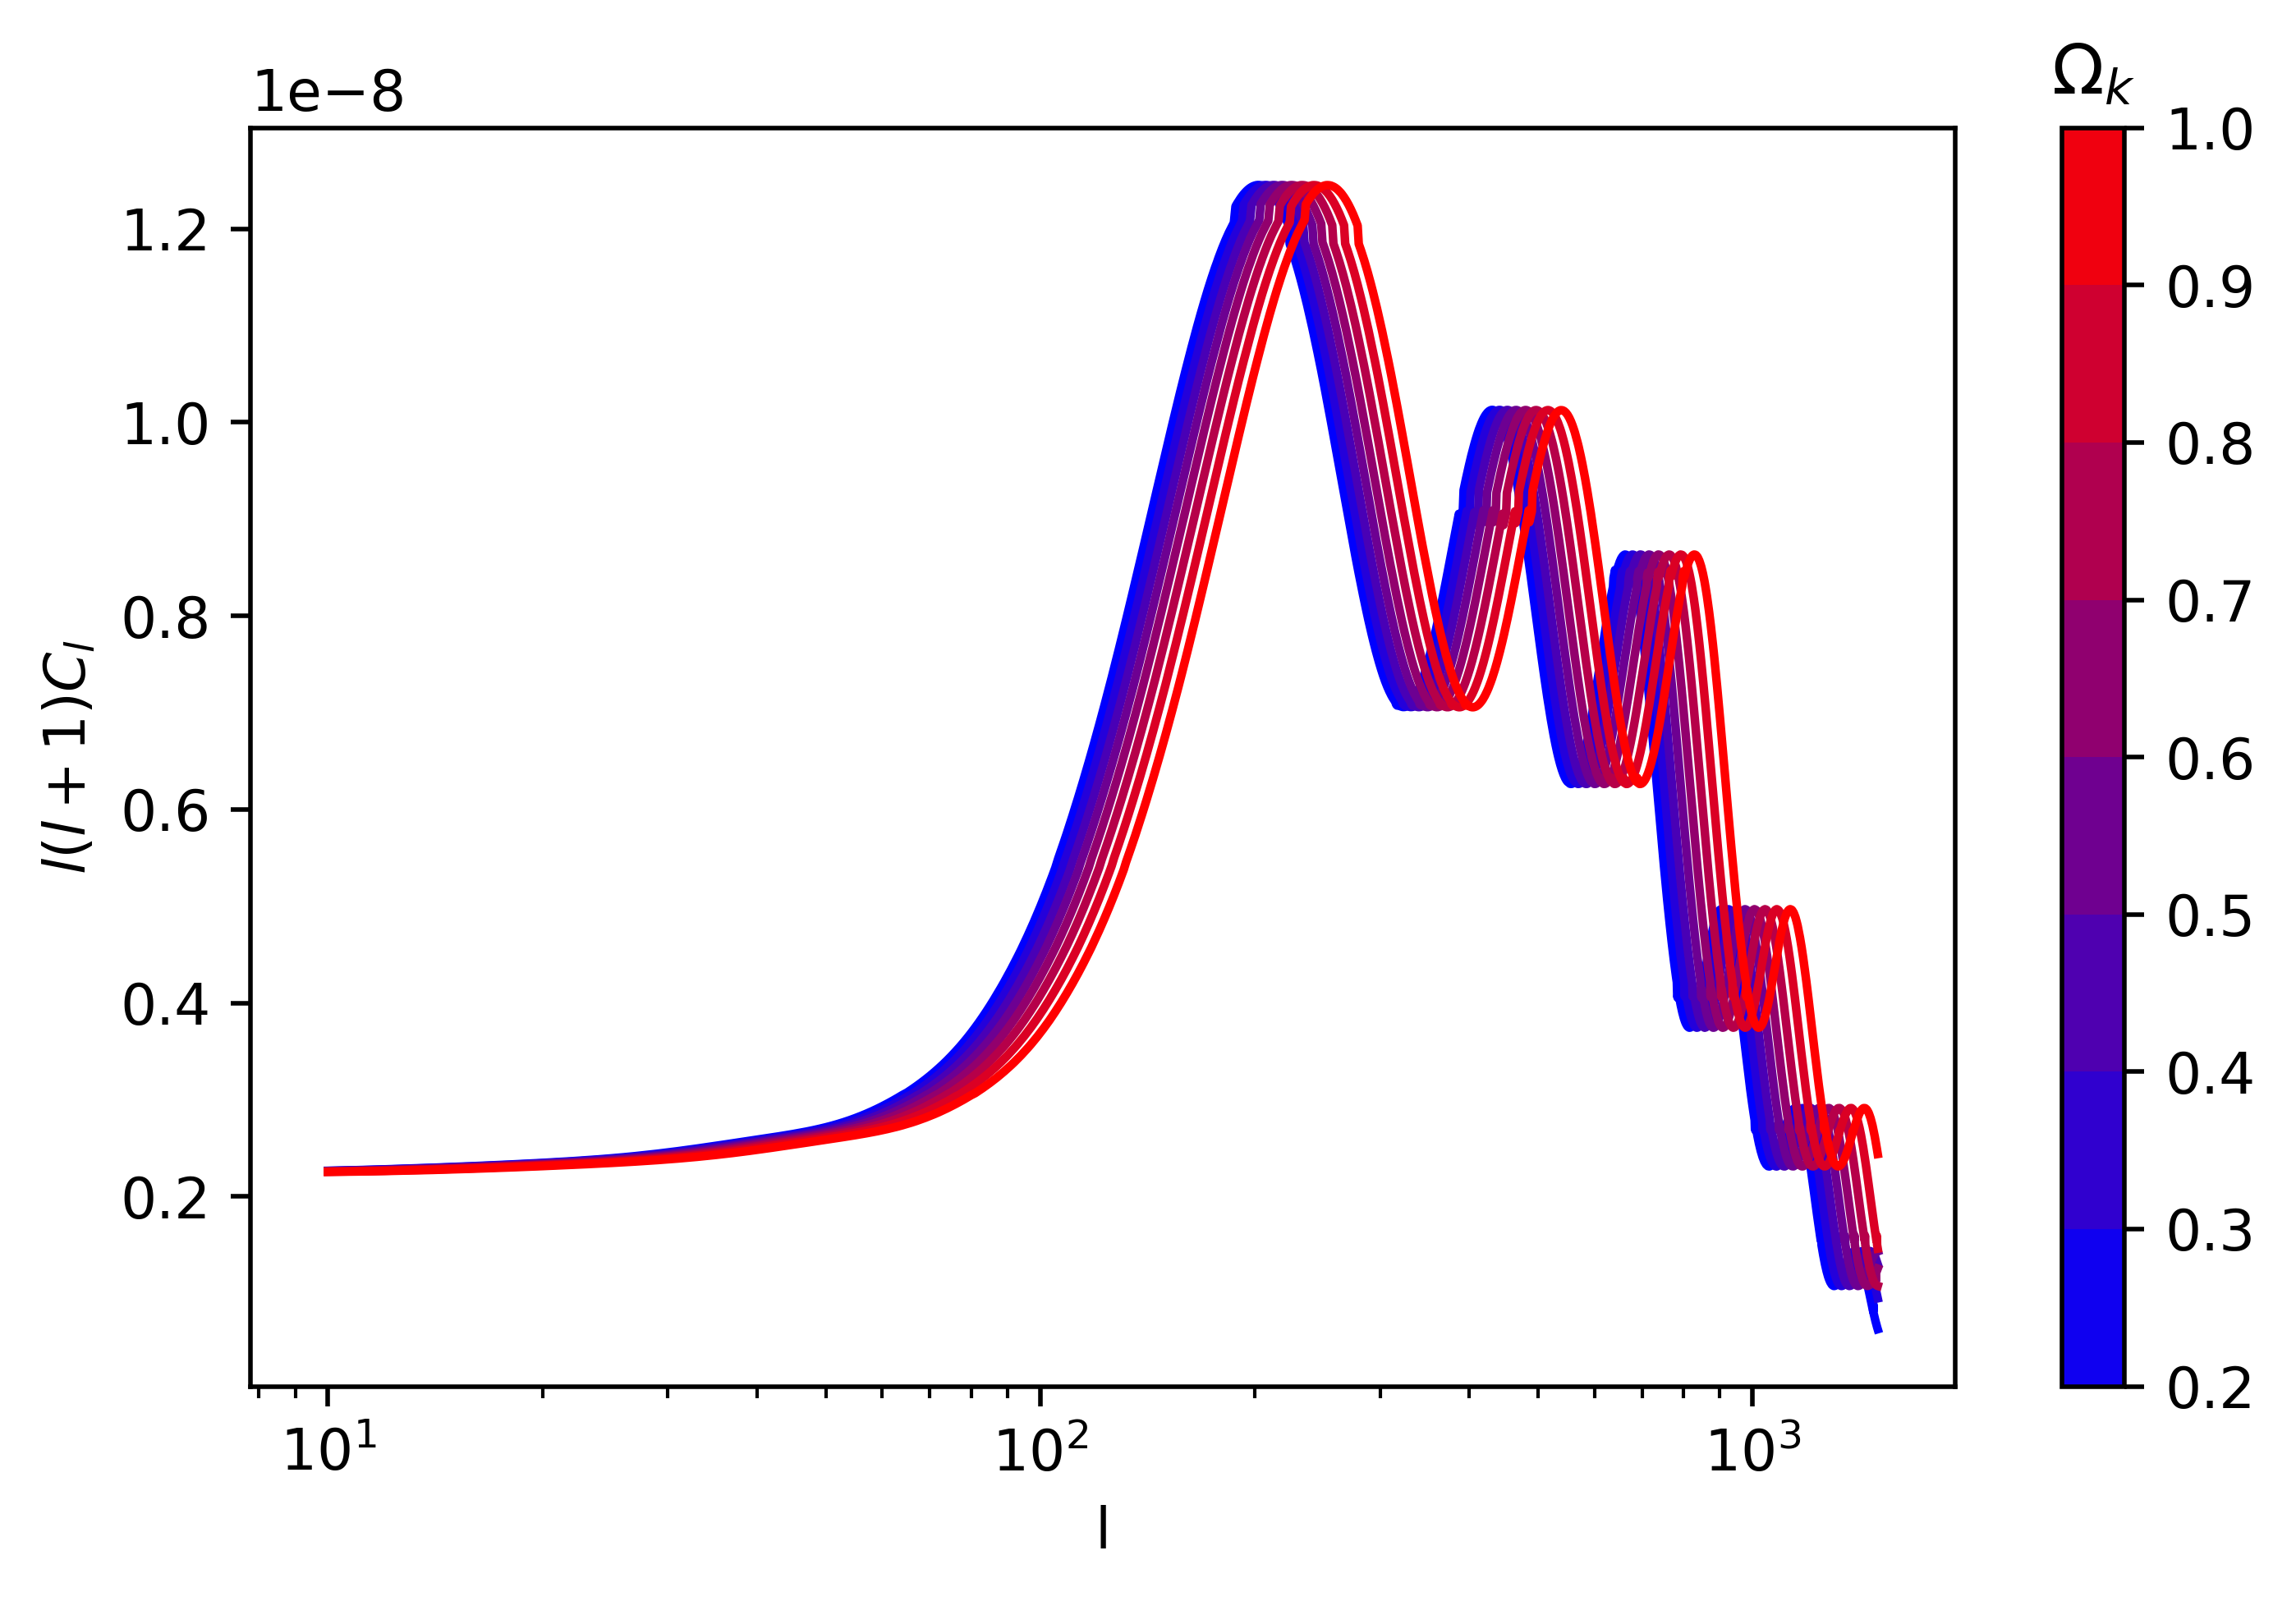

In [80]:
#HERE IS WHERE I VARY THE PARAMETERS omega_k
def init_params_k(h=0.7,omega_b = 0.053,omega_total = 1,omega_m = 0.229,omega_de = 0.7709,printing = 'False'):

    #Hubble today in 1/Mpc
    H_0 = 1/2997.9 * h
    omega_ph = 5.04E-5
    omega_c = omega_m - omega_b
    omega_k = 1-omega_total*(omega_ph + omega_m + omega_de)

    #omega_m = omega_b+omega_c

    f_nu = 1.68

    omega_r = f_nu*omega_ph

    a_rec = 1/1100

    a_eq = omega_r/omega_m

    alpha = np.sqrt(a_rec/a_eq)

    tau_r = np.sqrt(4*a_rec/omega_m/H_0**2) #constant tau_r in Mpc
    
    #integration limits
    xi = 1E-6
    x_rec_old = (np.sqrt(alpha**2+1)-1)/alpha #defined later on with a more detailed formula
    kmin = 0.01
    kmax = 300
    
    def tau(a, o_r, o_m, o_k, o_de):
        
        integrand = lambda x: 1/(H_0*x**2)*1/(np.sqrt(o_r/x**4+o_m/x**3+ o_k/x**2+o_de))
        
        tau_value , error = quad(integrand, 10**-15,a)
        
        return tau_value
    
    tau_rec = tau(a_rec, omega_r, omega_m, omega_k, omega_de)
    x_rec = tau_rec/tau_r #note the difference between tau_rec which is the conformal time at recombination
    #tau_r is really a rescaling parameter
    
    tau_0 = tau(1, omega_r, omega_m, omega_k, omega_de)
    tau_L = tau_0 - tau_rec #conformal time distance to recombination
    
    
    
    if printing == 'True':
        print(f'Initial parameters and derived quantities:')
        print(f'h = {h}, H_0 = {H_0}')
        print(f'omega_b = {omega_b}, omega_k = {omega_k}, omega_ph ={omega_ph}, omega_c = {omega_c}, omega_de = {omega_de}')
        print(f'Tau_r ={tau_r}, x_rec_old = {x_rec_old}, x_rec = {x_rec}')
        print(f'Tau_0 = {tau_0}, tau_rec = {tau_rec} and tau_L = {tau_L}')
        
    return (h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,omega_total, f_nu,omega_r, a_rec, a_eq, alpha,tau_r,xi, x_rec, tau_0, tau_L)

h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,omega_total, f_nu,omega_r, a_rec, a_eq, alpha,tau_r, xi, x_rec, tau_0, tau_L = init_params_k(printing='True')

def y(x):
    "computes scale factor y = a/a_eq in terms of time variable x = tau/tau_r, where tau is conformal time"

    return (alpha*x)**2+2*alpha*x

def yb(x):
    return omega_b/omega_m * y(x)

def yc(x):
    return omega_c/omega_m * y(x)

def eta(x):
    "computes hubble in rescaled units eta = (1/a)*da/dx"
    
    return 2*alpha*(alpha*x+1)/y(x)



lvals = np.arange(10,1500,1)
omega_k_list = np.linspace(0.2,1,8)

results_k_total = []
l_space_total = []
for iteration in tqdm(omega_k_list, desc=f'Computing PS for $\Omega_k$'):
    #print(f'Computing PS for $\Omega_k$ = {iteration}')
    h,H_0,omega_b,omega_k,omega_ph,omega_c,omega_de,omega_m,omega_total,f_nu,omega_r, a_rec, a_eq, alpha,tau_r,xi, x_rec, tau_0, tau_L  = init_params_k(omega_total = iteration, printing = 'False')
    l_space_total.append(lvals)
    results_k_total.append(power_spectrum(lvals))  
    pass


plotting_colorbar(omega_k_list, l_space_total, results_k_total, '$\Omega_k$')
#plt.savefig('PS_omega_k')